In [3]:
import pandas as pd
import lightgbm as lgb

df = pd.read_csv("../data/processed/training_table.csv")

y_true = df["is_fraud"].values



In [17]:
df.head()

,claim_id,claimant_id,provider_id,claim_amount,procedure_code,days_since_last_claim,claimant_base_risk,provider_base_risk,is_fraud,ae_score,...,gnn_emb_6,gnn_emb_7,gnn_emb_8,gnn_emb_9,gnn_emb_10,gnn_emb_11,gnn_emb_12,gnn_emb_13,gnn_emb_14,gnn_emb_15
0,1,3492,173,774.053333,10,59,0.134925,0.160851,0,0.420757,...,0.0,0.0,0.213976,0.107258,0.354122,0.263998,0.000000,0.139415,0.078057,0.106432
1,2,9390,1400,1152.977453,3,103,0.318920,0.214513,0,0.743365,...,0.0,0.0,0.264558,0.000000,0.593327,0.260324,0.000000,0.000000,0.139983,0.000000
2,3,572,948,2260.420933,9,0,0.350523,0.048763,0,2.718470,...,0.0,0.0,0.591214,0.000000,0.383469,0.043390,0.000000,0.099074,0.162554,0.000000
3,4,3972,879,3028.141322,9,13,0.381931,0.052359,0,4.840893,...,0.0,0.0,0.431731,0.000000,0.414974,0.381253,0.000000,0.267833,0.226197,0.095056
4,5,2145,98,885.676479,14,33,0.260551,0.038711,0,0.471366,...,0.0,0.0,0.141231,0.024482,0.339236,0.036846,0.003473,0.117936,0.099845,0.001279


In [4]:
model = lgb.Booster(model_file="../models/fraud_lgbm.txt")


In [5]:
exclude = ["claim_id", "claimant_id", "provider_id", "is_fraud"]
feature_cols = [c for c in df.columns if c not in exclude]

X = df[feature_cols]

In [ ]:
y_score = model.predict(X)

## ROC Curve

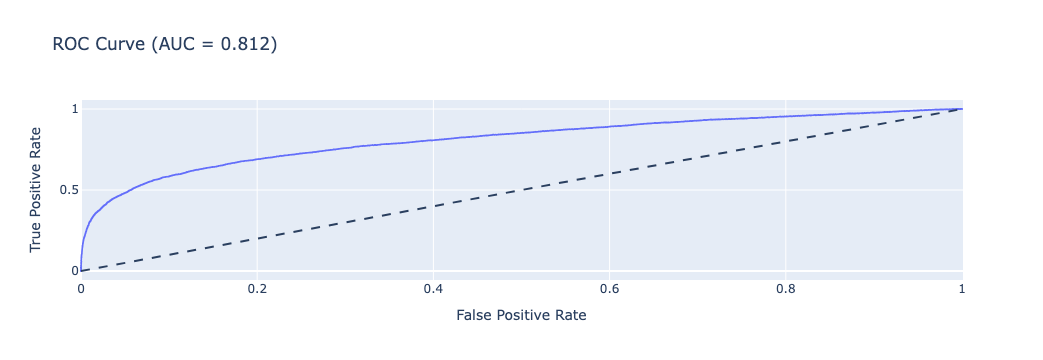

In [13]:
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)
import plotly.express as px

fig_roc = px.line(
    x=fpr, y=tpr,
    labels={"x": "False Positive Rate", "y": "True Positive Rate"},
    title=f"ROC Curve (AUC = {roc_auc:.3f})"
)
fig_roc.add_shape(type="line", x0=0, y0=0, x1=1, y1=1, line=dict(dash="dash"))
fig_roc.show()

## Precision–Recall Curve

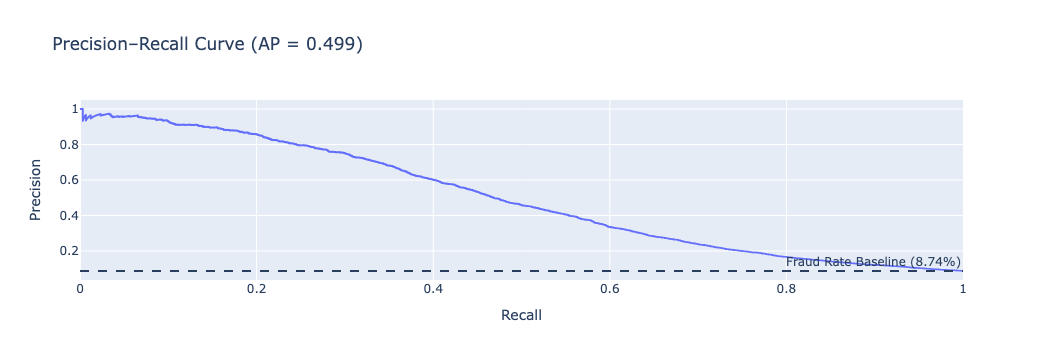

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import plotly.express as px

precision, recall, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)

fraud_rate = y_true.mean()

fig_pr = px.line(
    x=recall,
    y=precision,
    labels={"x": "Recall", "y": "Precision"},
    title=f"Precision–Recall Curve (AP = {ap:.3f})"
)

# Fraud-rate baseline
fig_pr.add_hline(
    y=fraud_rate,
    line_dash="dash",
    annotation_text=f"Fraud Rate Baseline ({fraud_rate:.2%})",
)

fig_pr.show()


## Precision@K / Recall@K

In [18]:
import numpy as np
import pandas as pd
import lightgbm as lgb

# Load training data
df = pd.read_csv("../data/processed/training_table.csv")

# Ground truth
y_true = df["is_fraud"].values

# Load trained model and recompute scores
model = lgb.Booster(model_file="../models/fraud_lgbm.txt")
exclude = ["claim_id", "claimant_id", "provider_id", "is_fraud"]
feature_cols = [c for c in df.columns if c not in exclude]
y_score = model.predict(df[feature_cols])

# Basic counts
N = len(y_true)
total_fraud = int(y_true.sum())
fraud_rate = total_fraud / N

print(f"Total claims: {N}")
print(f"Total fraud cases: {total_fraud}")
print(f"Fraud rate: {fraud_rate:.4%}")


Total claims: 50000
Total fraud cases: 4370
Fraud rate: 8.7400%


In [21]:
def recall_precision_at_k_with_counts(y_true, y_score, k_frac):
    n = len(y_score)
    k_count = int(np.ceil(k_frac * n))

    # Top K by score
    idx = np.argsort(-y_score)[:k_count]

    fraud_captured = int(y_true[idx].sum())
    precision_k = fraud_captured / max(k_count, 1)
    recall_k = fraud_captured / max(y_true.sum(), 1)

    return {
        "K (%)": f"{k_frac*100:.1f}%",
        "Claims Investigated": k_count,
        "Fraud Captured": fraud_captured,
        "Total Fraud": int(y_true.sum()),
        "Recall@K": recall_k,
        "Precision@K": precision_k,
    }


Ks = [0.005, 0.01, 0.02, 0.05]  # 0.5%, 1%, 2%, 5%

rows = [recall_precision_at_k_with_counts(y_true, y_score, k) for k in Ks]
df_recall_k = pd.DataFrame(rows)

df_recall_k


,K (%),Claims Investigated,Fraud Captured,Total Fraud,Recall@K,Precision@K
0,0.5%,250,240,4370,0.054920,0.9600
1,1.0%,500,460,4370,0.105263,0.9200
2,2.0%,1000,859,4370,0.196568,0.8590
3,5.0%,2500,1617,4370,0.370023,0.6468


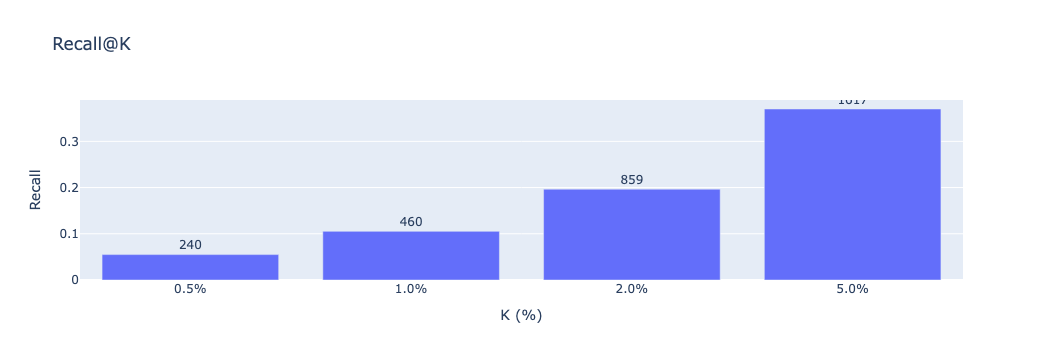

In [26]:
fig_k = px.bar(
    df_recall_k,
    x="K (%)",
    y="Recall@K",
    text=df_recall_k["Fraud Captured"],
    labels={"Recall@K": "Recall"},
    title="Recall@K"
)

fig_k.update_traces(textposition="outside")
fig_k.show()

In [10]:
metrics = {
    "roc": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "auc": round(float(roc_auc), 4)
    },
    "pr": {
        "precision": precision.tolist(),
        "recall": recall.tolist(),
        "ap": round(float(pr_auc), 4)
    },
    "recall_at_k": recall_at_k
}

with open("metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("metrics.json written successfully")


metrics.json written successfully
